# The problem

Based on this dataset with 20,000 chess matches collected from Lichess (games taken of users from the top ~100 teams on _lichess.org_ from 2013 to 2017) the objective is to create a model that predicts the result of a match, given the parameters of the game, before it starts (available at https://www.kaggle.com/datasnaek/chess).

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 200)

Populating the interactive namespace from numpy and matplotlib


Importing the dataset:

In [2]:
chess_games = pd.read_csv('games.csv', delimiter=',')

In [3]:
chess_games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Exploring the data

Let's explore the fields in order to suggest variables to create the model.

In [4]:
chess_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
id                20058 non-null object
rated             20058 non-null bool
created_at        20058 non-null float64
last_move_at      20058 non-null float64
turns             20058 non-null int64
victory_status    20058 non-null object
winner            20058 non-null object
increment_code    20058 non-null object
white_id          20058 non-null object
white_rating      20058 non-null int64
black_id          20058 non-null object
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_name      20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [5]:
chess_games.isnull().mean()

id                0.0
rated             0.0
created_at        0.0
last_move_at      0.0
turns             0.0
victory_status    0.0
winner            0.0
increment_code    0.0
white_id          0.0
white_rating      0.0
black_id          0.0
black_rating      0.0
moves             0.0
opening_eco       0.0
opening_name      0.0
opening_ply       0.0
dtype: float64

We don't have any missing values in the columns.

### Rated

In [6]:
chess_games['rated'].value_counts()

True     16155
False     3903
Name: rated, dtype: int64

We have more rated games than not.

### Date of Creation

In [7]:
pd.to_datetime(chess_games['created_at'], unit='ms').describe()

count                          20058
unique                         13151
top              2017-08-31 20:06:40
freq                              45
first     2013-08-17 20:33:53.173000
last      2017-09-04 02:45:43.790000
Name: created_at, dtype: object

The games were played between 08/2013 and 09/2017.

### Game delay and Time label

In [8]:
games_delay_in_sec = (chess_games['last_move_at'] - chess_games['created_at']) / 1000
games_delay_in_sec.describe()

count     20058.000000
mean        869.707050
std        4814.222091
min           0.000000
25%           0.000000
50%         240.612000
75%         793.171250
max      605844.701000
dtype: float64

The delays are the duration of the matches. From 0 (probably the last_move_at field was not registered) until 605844.7 seconds =~ 7 days, which may probably be an incorrect value or a match of correspondence chess, a possible variety of game at _lichess.org_.

### Turns

In [9]:
chess_games['turns'].describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

The min of 1 move may be most of aborted matches.

### Winner

In [10]:
chess_games['winner'].value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

### Victory Status

In [11]:
chess_games['victory_status'].value_counts()

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

We see that both 'winner' and 'victory_status' havea 'draw' filds, but with different values.

Let's analyse its distribution:

In [12]:
for vic_status in chess_games['victory_status'].unique():
    print(vic_status)
    print(chess_games[(chess_games['victory_status'] == vic_status) & (chess_games['winner'] == 'draw')].shape)
    print()

outoftime
(44, 16)

resign
(0, 16)

mate
(0, 16)

draw
(906, 16)



So there are matches that ended by 'outoftime' in a 'draw' result. This happens at insufficient material positions.

### Increment Code

These are the time controls of the matches.

In [13]:
chess_games['increment_code'].value_counts()

10+0     7721
15+0     1311
15+15     850
5+5       738
5+8       697
         ... 
35+15       1
60+4        1
120+5       1
19+20       1
17+2        1
Name: increment_code, Length: 400, dtype: int64

It seems like every entry in the field time control is of the form minutes+increment_seconds, we confirm that in the following command.

In [14]:
chess_games['increment_code'].str.match(pat='\d+[+]\d+').value_counts()

True    20058
Name: increment_code, dtype: int64

In [15]:
minutes = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None)
minutes = minutes.astype(int).value_counts().sort_index()
minutes

0        45
1        31
2        55
3        57
4        65
5      1795
6       176
7       661
8       924
9       261
10     9456
11       98
12      225
13       74
14       70
15     3382
16       49
17       40
18       26
19       28
20      936
21        1
25      322
29        2
30      746
35       26
40       37
45      158
60      103
90       26
120      16
150      13
180     154
Name: increment_code, dtype: int64

The greatest minutes field value is 180 min.

In [16]:
incr_seconds = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None)
incr_seconds = incr_seconds.astype(int).value_counts().sort_index()
incr_seconds

0      11098
1        234
2        657
3        456
4        168
5       2068
6        185
7        181
8       1220
9        112
10      1401
11        28
12        87
13        16
14        59
15      1167
16        26
17        30
18        11
19         7
20       125
21         6
25        62
30       297
35         7
40        41
45       107
60       105
90         2
120        4
150        2
180       89
Name: increment_code, dtype: int64

The max increment is 180 seconds per move (1 minute 30 seconds).

### Ratings

For White:

In [17]:
chess_games['white_rating'].describe()

count    20058.000000
mean      1596.631868
std        291.253376
min        784.000000
25%       1398.000000
50%       1567.000000
75%       1793.000000
max       2700.000000
Name: white_rating, dtype: float64

For Black:

In [18]:
chess_games['black_rating'].describe()

count    20058.000000
mean      1588.831987
std        291.036126
min        789.000000
25%       1391.000000
50%       1562.000000
75%       1784.000000
max       2723.000000
Name: black_rating, dtype: float64

Both vary between [291, ~2700].

### Opening ECO

In [19]:
chess_games['opening_eco'].value_counts()

A00    1007
C00     844
D00     739
B01     716
C41     691
       ... 
B62       1
E47       1
D58       1
E33       1
C32       1
Name: opening_eco, Length: 365, dtype: int64

## New variables

### Duration of the match

In [20]:
chess_games['duration_in_seconds'] = games_delay_in_sec.copy()

### One-Hot-Encoding of victory status

In [21]:
from category_encoders import OneHotEncoder

In [22]:
ohe_victory_status = OneHotEncoder(cols=['victory_status'], use_cat_names=True, drop_invariant=True)
chess_games = ohe_victory_status.fit_transform(chess_games)

### Time control: Minutes and Seconds

In [23]:
minutes = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None).astype(int)
incr_seconds = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None).astype(int)

chess_games['minutes'] = minutes.copy()
chess_games['incr_seconds'] = incr_seconds.copy()

In [24]:
chess_games = chess_games.drop(columns=['increment_code'], axis=1)

### Date of Creation and Last Move At (as dates)

In [25]:
chess_games['created_at'] = pd.to_datetime(chess_games['created_at'], unit='ms')
chess_games['last_move_at'] = pd.to_datetime(chess_games['last_move_at'], unit='ms')

### Winner

This is the target field.

The idea is to encode each result as follows:

- White: +3
- Draw = 0
- Black -3

In [26]:
def transform_winner(field):
    if field == 'white':
        return 3
    elif field == 'black':
        return -3
    else:
        return 0
        
chess_games['winner'] = chess_games['winner'].transform(transform_winner)

As so, the predictions for 'winner' field must lie on [-3, 3]. The choice of these values is due to the choice of category being easier to determine:

- [-3, -1]: Black won
- [-1, +1]: Draw
- [+1, +3]: White won

In [27]:
chess_games.tail()

,id,rated,created_at,last_move_at,turns,victory_status_outoftime,victory_status_resign,victory_status_mate,victory_status_draw,winner,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration_in_seconds,minutes,incr_seconds
20053,EfqH7VVH,True,2017-07-11 16:35:14.342,2017-07-11 16:40:36.076,24,0,1,0,0,3,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2,321.734,10,10
20054,WSJDhbPl,True,2017-07-10 14:48:09.760,2017-07-10 15:00:33.979,82,0,0,1,0,-3,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2,744.219,10,0
20055,yrAas0Kj,True,2017-07-10 14:44:37.493,2017-07-10 14:47:30.327,35,0,0,1,0,3,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3,172.834,10,0
20056,b0v4tRyF,True,2017-07-10 14:15:27.019,2017-07-10 14:31:13.718,109,0,1,0,0,3,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4,946.699,10,0
20057,N8G2JHGG,True,2017-07-09 23:32:32.649,2017-07-09 23:44:49.348,78,0,0,1,0,-3,jamboger,1235,ffbob,1339,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,D00,Queen's Pawn Game: Mason Attack,3,736.699,10,0


## Clean Data

Let's plot the distribution of duration in seconds for the dataset.

We define a maximum threshold for the delay of the matches (in hours).

It's based on the maximum number of minutes, max of increment seconds by move and the mean quantity of moves in a match of the dataset.

It supposes all the time is consumed in the match.

In [28]:
max_minutes = chess_games['minutes'].max()
max_incr_seconds = chess_games['incr_seconds'].max()
mean_moves = chess_games['turns'].mean()

duration_threshold_in_hours = (max_minutes + max_incr_seconds / 60 * mean_moves) / 60
duration_threshold_in_hours

6.0232999302024135

Let's separate the matches that, theoretically, take more than 6 hours to finish.

In [29]:
(chess_games['duration_in_seconds'] < duration_threshold_in_hours * 3600).value_counts()

True     20054
False        4
Name: duration_in_seconds, dtype: int64

In [30]:
chess_games_flagged_duration = chess_games[chess_games['duration_in_seconds'] >= duration_threshold_in_hours * 3600]
chess_games = chess_games[chess_games['duration_in_seconds'] < duration_threshold_in_hours * 3600]

In [31]:
chess_games.shape

(20054, 21)

In [32]:
chess_games_flagged_duration.shape

(4, 21)

Let's evaluate those matches with duration equal to 0.

In [33]:
(chess_games['duration_in_seconds'] == 0).value_counts()

False    11506
True      8548
Name: duration_in_seconds, dtype: int64

What are the results for these matches?

In [34]:
duration0 = chess_games[chess_games['duration_in_seconds'] == 0]
duration0['winner'].value_counts()

 3    4248
-3    3938
 0     362
Name: winner, dtype: int64

So, there are not only draws (it would be possible to register as draws aborted matches, for example, we see that's not the case).

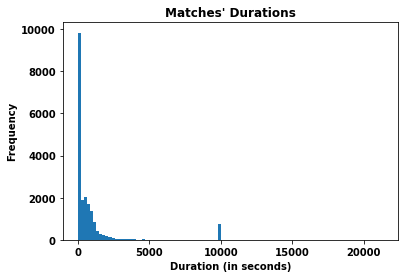

In [36]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

Let's separate the matches that duration_in_seconds == 0.

In [39]:
chess_games_flagged_duration_eq0 = chess_games[chess_games['duration_in_seconds'] == 0]
chess_games_flagged_duration = pd.concat([chess_games_flagged_duration, chess_games_flagged_duration_eq0], ignore_index=False)
chess_games = chess_games[chess_games['duration_in_seconds'] > 0]

In [41]:
chess_games.shape

(11506, 21)

In [43]:
chess_games_flagged_duration.shape

(8552, 21)

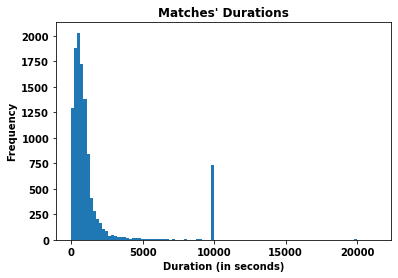

In [44]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

For our analysis, we'll drop out the variable 'duration_in_seconds' for the samples where duration_in_seconds == 0 or duration_in_seconds > 6 hours.

So, for chess_games_flagged_duration we won't consider 'duration_in_seconds' in the model, while for chess_games we will.

The peak at ~10000 s = ~2.7 hours, which is a plausible match duration.

## Validation

50% treino 50% valid 